In [1]:
# ── imports ──────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# generation
from lhcb_velo_toy.generation import (
    PlaneGeometry,
    StateEventGenerator,
)

# solvers
from lhcb_velo_toy.solvers import (
    SimpleHamiltonianFast,
    get_tracks,
)

# analysis
from lhcb_velo_toy.analysis import EventValidator, Match
from lhcb_velo_toy.analysis.plotting.event_display import (
    plot_event_3d,
    plot_reco_vs_truth,
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

# ── helper: build geometry from high-level parameters ───────────
def make_geometry(n_modules: int, z_first: float = 100.0, z_spacing: float = 33.0,
                  half_x: float = 50.0, half_y: float = 50.0) -> PlaneGeometry:
    """Create a PlaneGeometry with evenly spaced modules."""
    z_positions = [z_first + i * z_spacing for i in range(n_modules)]
    return PlaneGeometry(
        module_id=list(range(n_modules)),
        lx=[half_x] * n_modules,
        ly=[half_y] * n_modules,
        z=z_positions,
    )

# ── helper: generate a complete event ───────────────────────────
def generate_event(geo, n_tracks, measurement_error=0.0, collision_noise=1e-8,
                   phi_max=0.2, theta_max=0.2):
    """Generate a full event end-to-end."""
    gen = StateEventGenerator(
        detector_geometry=geo,
        events=1,
        n_particles=[n_tracks],
        phi_min=-phi_max, phi_max=phi_max,
        theta_min=-theta_max, theta_max=theta_max,
        measurement_error=measurement_error,
        collision_noise=collision_noise,
    )
    gen.generate_random_primary_vertices({"x": 0.1, "y": 0.1, "z": 50.0})
    particles = [[{"type": "pion", "mass": 139.6, "q": 1}] * n_tracks]
    gen.generate_particles(particles)
    event = gen.generate_complete_events()
    return gen, event

print("All imports successful.")

All imports successful.


In [2]:
# ── generate a clean event ──────────────────────────────────────
# 5 modules, 33mm spacing (z: 100-232mm), 50mm half-width
# With max slopes ~0.2 rad, tracks travel ~26mm laterally over 132mm in z
# → all tracks stay well within acceptance
N_TRACKS_CLEAN = 3
N_MODULES_CLEAN = 5

geo_clean = make_geometry(N_MODULES_CLEAN, z_spacing=33.0)

# Retry until we get an event where every track has >= 3 hits
# (rare acceptance losses can occur at boundaries)
for attempt in range(20):
    gen_clean, event_clean = generate_event(geo_clean, N_TRACKS_CLEAN)
    min_hits = min(len(t.hit_ids) for t in event_clean.tracks)
    if min_hits >= 3:
        break

print(f"Clean event: {len(event_clean.tracks)} tracks, "
      f"{len(event_clean.hits)} hits across {len(event_clean.modules)} modules")
for trk in event_clean.tracks:
    print(f"  Track {trk.track_id}: {len(trk.hit_ids)} hits")

Clean event: 3 tracks, 13 hits across 5 modules
  Track 0: 4 hits
  Track 1: 4 hits
  Track 2: 5 hits


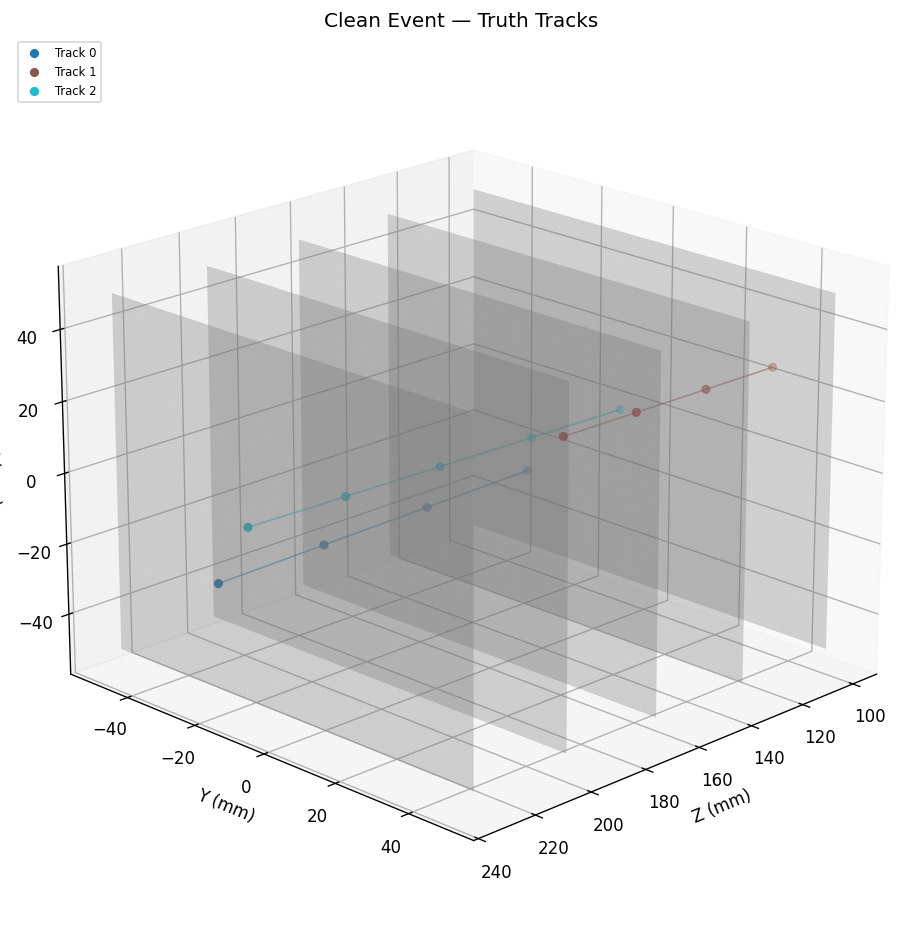

In [3]:
# ── 3-D truth display ───────────────────────────────────────────
fig_truth = plot_event_3d(event_clean, title="Clean Event — Truth Tracks")
plt.show()

In [4]:
# ── build Hamiltonian & solve classically ────────────────────────
EPSILON = 0.01   # angular tolerance (rad)
GAMMA   = 1.5    # self-interaction penalty
DELTA   = 1.0    # bias weight

ham_clean = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
A_clean, b_clean = ham_clean.construct_hamiltonian(event_clean)
x_clean = ham_clean.solve_classicaly()

# An uncoupled (fake) segment has activation δ/(δ+γ).
# True segments, boosted by collinear couplings, sit above this.
BASELINE = DELTA / (DELTA + GAMMA)
THRESHOLD = (1 + BASELINE) / 2          # midpoint → clear separator

print(f"Segments:  {ham_clean.n_segments}")
print(f"Matrix A:  {A_clean.shape[0]}×{A_clean.shape[1]}, nnz={A_clean.nnz}")
print(f"Uncoupled baseline:  x ≈ {BASELINE:.3f}")
print(f"Threshold:           {THRESHOLD:.3f}")
print(f"Active (above thr):  {np.sum(x_clean > THRESHOLD)} / {len(x_clean)} segments")
print(f"Min / Max activation: {x_clean.min():.4f} / {x_clean.max():.4f}")

Segments:  30
Matrix A:  30×30, nnz=44
Uncoupled baseline:  x ≈ 0.400
Threshold:           0.700
Active (above thr):  10 / 30 segments
Min / Max activation: 0.4000 / 1.2727


In [5]:
# ── reconstruct tracks ──────────────────────────────────────────
reco_clean = get_tracks(ham_clean, x_clean, event_clean, threshold=THRESHOLD)
print(f"Reconstructed {len(reco_clean)} tracks")
for trk in reco_clean:
    print(f"  Reco track {trk.track_id}: {len(trk.hit_ids)} hits")

Reconstructed 3 tracks
  Reco track 0: 4 hits
  Reco track 1: 4 hits
  Reco track 2: 5 hits


In [6]:
event_clean

Event(detector_geometry=PlaneGeometry(module_id=[0, 1, 2, 3, 4], lx=[50.0, 50.0, 50.0, 50.0, 50.0], ly=[50.0, 50.0, 50.0, 50.0, 50.0], z=[100.0, 133.0, 166.0, 199.0, 232.0]), primary_vertices=[PrimaryVertex(pv_id=0, x=-0.05728763304284943, y=0.06085701684633474, z=-131.82477697855916, track_ids=[0, 1, 2], extra={})], tracks=[Track(track_id=0, pv_id=0, hit_ids=[0, 1, 2, 3], extra={}), Track(track_id=1, pv_id=0, hit_ids=[4, 5, 6, 7], extra={}), Track(track_id=2, pv_id=0, hit_ids=[8, 9, 10, 11, 12], extra={})], hits=[Hit(hit_id=0, x=-27.947220773063457, y=-33.913745452016826, z=100.0, module_id=0, track_id=0, extra={}), Hit(hit_id=1, x=-31.917321657210426, y=-38.74999186124535, z=133.0, module_id=1, track_id=0, extra={}), Hit(hit_id=2, x=-35.88742273204262, y=-43.58623864548865, z=166.0, module_id=2, track_id=0, extra={}), Hit(hit_id=3, x=-39.857523982365784, y=-48.42248540343192, z=199.0, module_id=3, track_id=0, extra={}), Hit(hit_id=4, x=24.49499482640363, y=34.09819866499768, z=100.0,

In [7]:
type(reco_clean[0])

lhcb_velo_toy.generation.entities.track.Track

In [8]:
reco_hits = [hit_id for trk in reco_clean for hit_id in trk.hit_ids]

In [9]:
from lhcb_velo_toy.solvers.reconstruction import construct_event

In [10]:
# Extract Hit objects corresponding to the reconstructed hit IDs
reco_hit_objects = [hit for hit in event_clean.hits if hit.hit_id in reco_hits]

event_reco = construct_event(
    detector_geometry=geo_clean,
    tracks=reco_clean,
    hits=reco_hit_objects
)

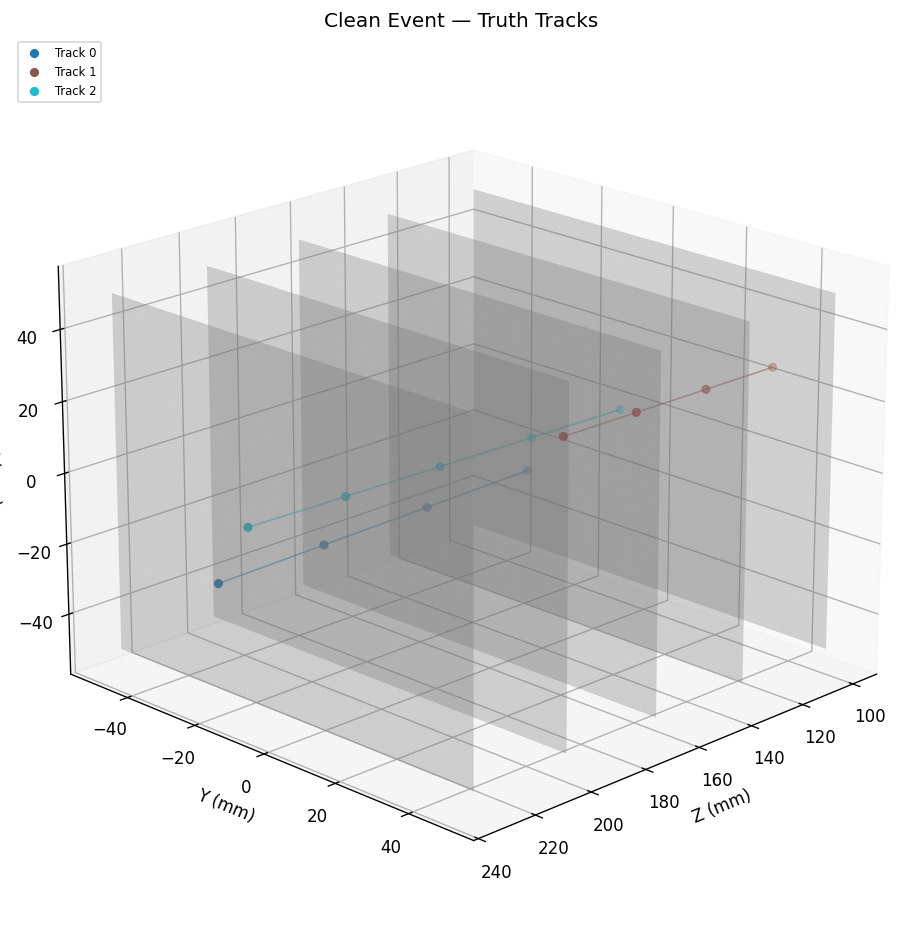

In [11]:
# ── 3-D truth display ───────────────────────────────────────────
fig_truth = plot_event_3d(event_clean, title="Clean Event — Truth Tracks")
plt.show()

In [12]:
# ── validate: match reco → truth ────────────────────────────────
val_clean = EventValidator(event_clean, reco_clean)
matches_clean, metrics_clean = val_clean.match_tracks(purity_min=0.7)

print("=== Clean Event Metrics ===")
for k, v in metrics_clean.items():
    print(f"  {k:25s}: {v}")

# per-track detail
print("\nPer-track matches:")
print(f"  {'Truth':>6}  {'RecHits':>7}  {'Purity':>7}  {'HitEff':>7}  {'Type'}")
for m in matches_clean:
    label = "PRIMARY" if m.is_primary else ("GHOST" if m.is_ghost else "CLONE")
    truth_str = str(m.truth_id) if m.truth_id is not None else "-"
    print(f"  {truth_str:>6}  {m.rec_hits:7d}  "
          f"{m.purity:7.3f}  {m.hit_efficiency:7.3f}  {label}")

=== Clean Event Metrics ===
  efficiency               : 1.0
  ghost_rate               : 0.0
  clone_fraction           : 0.0
  mean_purity              : 1.0
  hit_efficiency           : 1.0
  n_candidates             : 3
  n_accepted               : 3
  n_ghosts                 : 0
  n_clones                 : 0
  n_primary                : 3
  n_reconstructible        : 3
  n_matched                : 3

Per-track matches:
   Truth  RecHits   Purity   HitEff  Type
       0        4    1.000    1.000  PRIMARY
       1        4    1.000    1.000  PRIMARY
       2        5    1.000    1.000  PRIMARY
